In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
### Phase 1: Create Virtual Fleet from Real Refrigerator Data
---

In [2]:
def create_virtual_fleet_smooth(source_df, n_simulated=1000):
    """
    Simulates a fleet using the 'Tile and Slice' method to eliminate
    edge spikes and harmonics.
    """
    source_matrix = source_df.values
    n_source_cols = source_matrix.shape[1]
    n_timesteps = source_matrix.shape[0]  # e.g., 1440 minutes
    
    # 1. Tile the data 3 times (Day-1, Day, Day+1)
    # This creates a buffer so we can slide the window without wrapping abruptly
    # Shape becomes (4320, n_source_cols)
    tiled_source = np.tile(source_matrix, (3, 1))
    
    # 2. Assign profiles
    assigned_profiles = np.random.randint(0, n_source_cols, n_simulated)
    
    # 3. Generate Random Start Offsets (The "Scramble")
    # We pick a random start minute anywhere within the first 24 hours (0 to 1440)
    start_offsets = np.random.randint(0, n_timesteps, n_simulated)
    
    # 4. Aggregate
    total_fleet_load = np.zeros(n_timesteps)
    
    # Vectorized accumulation
    # We iterate through the simulated units (or batches of them for speed)
    # For a few thousand units, a simple loop is actually quite fast with Numpy slicing
    for i in range(n_simulated):
        src_idx = assigned_profiles[i]
        offset = start_offsets[i]
        
        # SLICE the continuous window from the tiled matrix
        # We take 1440 minutes starting from the random offset
        # This guarantees a smooth, unbroken profile for every fridge
        fridge_profile = tiled_source[offset : offset + n_timesteps, src_idx]
        
        total_fleet_load += fridge_profile
            
    return total_fleet_load

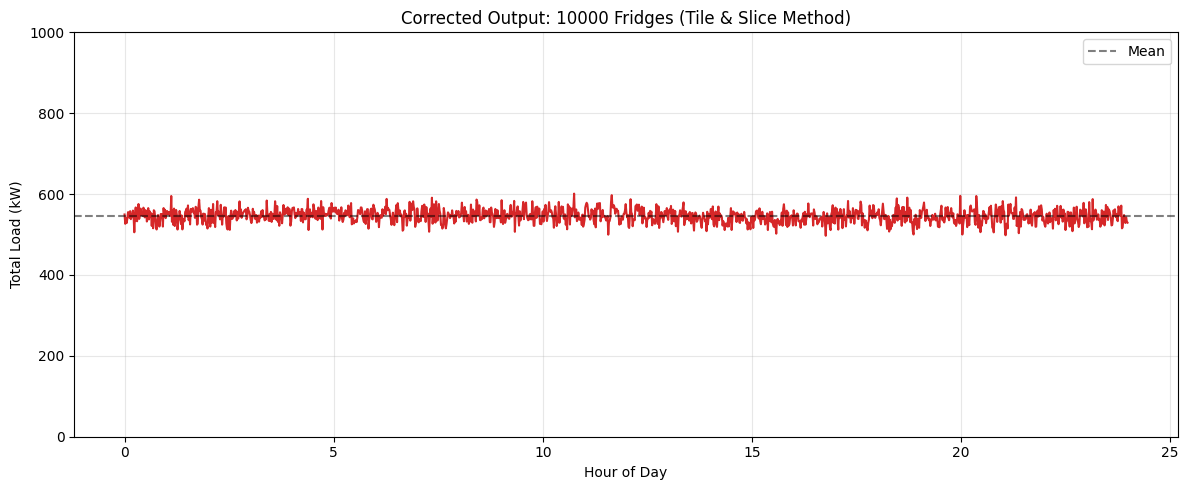

In [3]:
# ==========================================
# EXECUTION
# ==========================================

# 1. Generate Dummy Data (or load your real csv)
# Note: Ensure your dummy data is roughly 1440 rows (1 day)
source_df = pd.read_csv('data/fridge_power.csv')

# 2. Run the Smoothed Simulation
N_FRIDGES = 10000
aggregate_load = create_virtual_fleet_smooth(source_df, N_FRIDGES)

# 3. Plot
plt.figure(figsize=(12, 5))
time_axis = np.arange(1440) / 60  # Hours

plt.plot(time_axis, aggregate_load / 1000, color='#d62728', linewidth=1.5)
plt.title(f"Corrected Output: {N_FRIDGES} Fridges (Tile & Slice Method)")
plt.ylabel("Total Load (kW)")
plt.xlabel("Hour of Day")
plt.grid(True, alpha=0.3)

# Add a dashed line for the mean to check flatness
plt.axhline(y=np.mean(aggregate_load/1000), color='black', linestyle='--', alpha=0.5, label="Mean")
plt.legend()

plt.ylim([0, 1000])
plt.tight_layout()
plt.show()

---
### Phase 2: Simulate Demand Response
---

In [4]:
def simulate_demand_response(
    baseline_load_kw, 
    n_fridges, 
    batt_capacity_wh, 
    batt_power_w, 
    event_start_hour=17, 
    event_end_hour=19,
    recharge_window_hours=4
):
    """
    Simulates a battery-backed fleet responding to a peak event.
    
    Args:
        baseline_load_kw (array): The 1-minute interval load profile (kW)
        n_fridges (int): Number of units
        batt_capacity_wh (float): Capacity per fridge (Watt-hours)
        batt_power_w (float): Max discharge rate per fridge (Watts)
        event_start/end_hour (float): The DR window (e.g., 17 = 5 PM)
        recharge_window_hours (float): How long the fleet takes to recharge
        
    Returns:
        pd.DataFrame with columns: ['Baseline', 'With_DR', 'Battery_SoC', 'Action']
    """
    
    # 1. Scale Battery Specs to Fleet Level (convert to kW and kWh)
    fleet_capacity_kwh = (n_fridges * batt_capacity_wh) / 1000
    fleet_max_power_kw = (n_fridges * batt_power_w) / 1000
    
    # Time setup
    minutes = len(baseline_load_kw)
    time_indices = np.arange(minutes)
    
    # Convert hours to minute indices
    start_idx = int(event_start_hour * 60)
    end_idx = int(event_end_hour * 60)
    recharge_end_idx = min(minutes, int(end_idx + (recharge_window_hours * 60)))
    
    # Initialize arrays
    new_load_kw = baseline_load_kw.copy()
    soc_kwh = np.full(minutes, fleet_capacity_kwh) # Start full
    action_log = np.zeros(minutes) # For visualization (positive=discharge)
    
    # ==========================================
    # SIMULATION LOOP
    # ==========================================
    
    current_soc = fleet_capacity_kwh
    
    for t in range(minutes):
        
        # A. DISCHARGE LOGIC (During Peak Window)
        if start_idx <= t < end_idx:
            if current_soc > 0:
                # 1. How much do we WANT to discharge? (Cap at max power)
                target_discharge = fleet_max_power_kw
                
                # 2. How much energy do we HAVE? (kWh -> kW conversion)
                # Energy = Power * Time. So Power = Energy / (1/60 hours)
                max_energy_discharge_kw = current_soc * 60 
                
                # 3. How much load is ACTUALLY there? (Can't discharge more than load)
                # (Assuming no grid backfeeding allowed)
                real_load_limit = new_load_kw[t]
                
                # The actual discharge is the minimum of all constraints
                actual_discharge_kw = min(target_discharge, max_energy_discharge_kw, real_load_limit)
                
                # Apply
                new_load_kw[t] -= actual_discharge_kw
                current_soc -= (actual_discharge_kw / 60) # Convert kW back to kWh
                action_log[t] = -actual_discharge_kw
                
        # B. RECHARGE LOGIC (After Peak Window)
        elif end_idx <= t < recharge_end_idx:
            # Calculate how much energy is missing
            missing_energy = fleet_capacity_kwh - current_soc
            
            if missing_energy > 0:
                # Simple linear recharge distribution
                # (In reality, this follows a CC/CV curve, but linear is fine for grid sim)
                remaining_minutes = recharge_end_idx - t
                recharge_rate_kw = (missing_energy * 60) / remaining_minutes
                
                # Cap recharge rate at max power (batteries limit charge speed too)
                recharge_rate_kw = min(recharge_rate_kw, fleet_max_power_kw)
                
                new_load_kw[t] += recharge_rate_kw
                current_soc += (recharge_rate_kw / 60)
                action_log[t] = recharge_rate_kw

        # Store State of Charge
        soc_kwh[t] = current_soc

    # Package results
    return pd.DataFrame({
        'Baseline': baseline_load_kw,
        'With_DR': new_load_kw,
        'Battery_SoC': soc_kwh,
        'Battery_Action': action_log
    })

In [44]:
# ==========================================
# EXECUTE
# ==========================================

# Define Specs (Example: A typical 100Ah 12V LFP battery is ~1200Wh)
BATTERY_CAPACITY_WH = 500  # Conservative small backup
DISCHARGE_RATE_W = 500     # Rate limit

peak_start = 16
peak_end = 21

df_result = simulate_demand_response(
    baseline_load_kw=aggregate_load/1000, # Ensure we pass kW
    n_fridges=10000,
    batt_capacity_wh=BATTERY_CAPACITY_WH,
    batt_power_w=DISCHARGE_RATE_W,
    event_start_hour=peak_start,    # 5:00 PM
    event_end_hour=peak_end,      # 9:00 PM (4 hour peak)
    recharge_window_hours=3 # Spread recovery over 3 hours
)

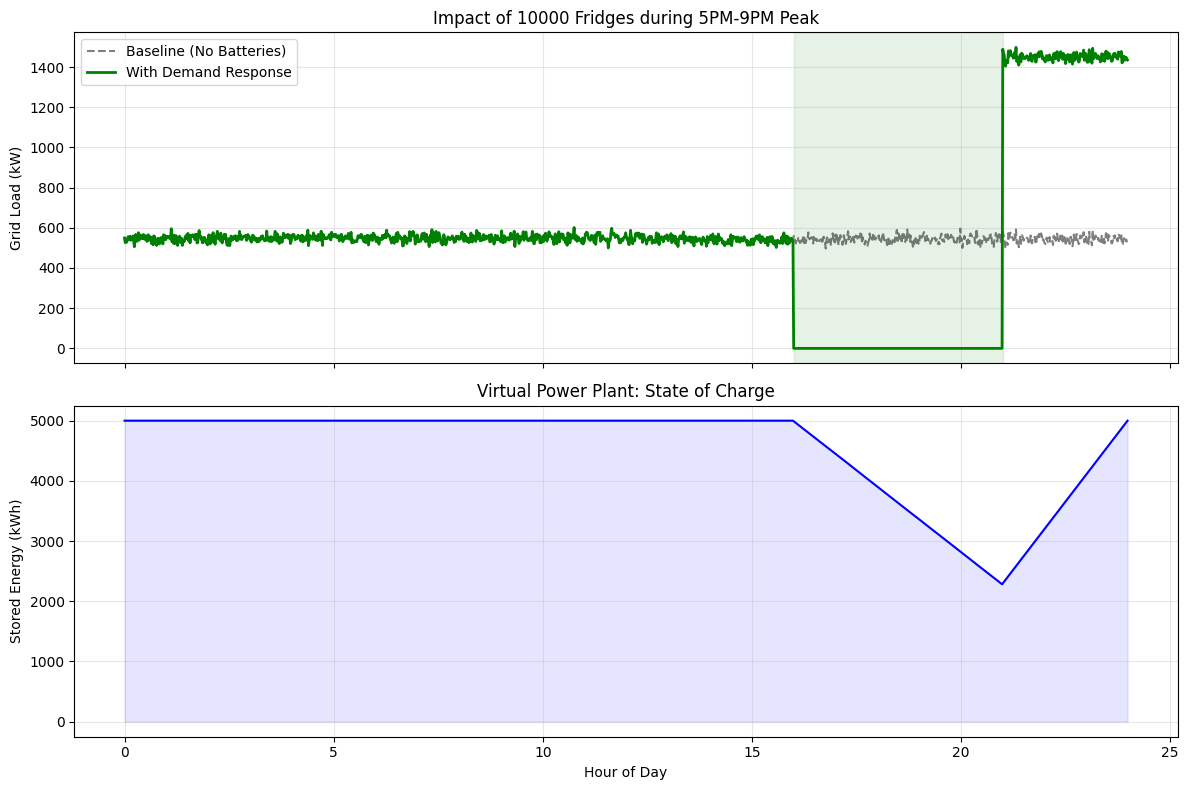

In [45]:
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Load Impact
ax1.plot(df_result.index/60, df_result['Baseline'], 'k--', alpha=0.5, label='Baseline (No Batteries)')
ax1.plot(df_result.index/60, df_result['With_DR'], 'g-', linewidth=2, label='With Demand Response')
ax1.set_ylabel('Grid Load (kW)')
ax1.set_title(f"Impact of {10000} Fridges during 5PM-9PM Peak")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Highlight the DR window
ax1.axvspan(peak_start, peak_end, color='green', alpha=0.1, label='DR Window')

# Plot 2: Battery State
ax2.plot(df_result.index/60, df_result['Battery_SoC'], 'b-', label='Aggregate Battery Energy')
ax2.set_ylabel('Stored Energy (kWh)')
ax2.set_xlabel('Hour of Day')
ax2.set_title('Virtual Power Plant: State of Charge')
ax2.fill_between(df_result.index/60, df_result['Battery_SoC'], color='blue', alpha=0.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
### Phase 3: Integrate with Grid Load Data
---

In [7]:
hourly_load = pd.read_csv('data/isone_hourly.csv')
hourly_load['timestamp'] = pd.to_datetime(hourly_load['timestamp'])
hourly_load.set_index('timestamp', inplace=True)

In [8]:
# ==========================================
# 1. PREPARE GRID DATA (Hourly -> Minute)
# ==========================================
# (Replace with your actual Grid CSV loading)
# Example: 24 hours of ISO-NE data (Peak ~18,000 MW)
day = '2024-07-15'

dstart = pd.to_datetime(day + ' 00:00')
dend = dstart + pd.Timedelta(days=1, minutes=1)

grid_load_hourly = hourly_load.loc[dstart:dend]
grid_load_hourly.index = pd.date_range(dstart, dend, freq='h')

# Interpolate to minutes (Cubic Spline for smoothness)
df_grid_min = grid_load_hourly.resample('1min').asfreq()
df_grid_min['Load_MW'] = df_grid_min['Load_MW'].interpolate(method='cubic')

In [46]:
# ==========================================
# 2. CALCULATE THE DELTA
# ==========================================
# We assume df_result is available from Phase 2
# df_result columns: ['Baseline', 'With_DR'] (in kW)

# Calculate the difference the fleet makes (in kW)
fleet_delta_kw = df_result['With_DR'] - df_result['Baseline']

# SCALING FACTOR
# Your sim had 10,000 fridges.
# There are ~5.6 million households in New England.
# Let's verify "What if 1 million homes (approx 18%) participated?"
SIMULATED_COUNT = 10000
TARGET_DEPLOYMENT = 1000000 
SCALER = TARGET_DEPLOYMENT / SIMULATED_COUNT

# Convert Delta to MW and Scale up
fleet_delta_mw_scaled = (fleet_delta_kw / 1000) * SCALER

# ==========================================
# 3. MERGE & COMPARE
# ==========================================
# Truncate grid data to match simulation length if necessary
sim_len = len(fleet_delta_mw_scaled)
original_grid_profile = df_grid_min['Load_MW'].values[:sim_len]

# Apply the Delta
new_grid_profile = original_grid_profile + fleet_delta_mw_scaled

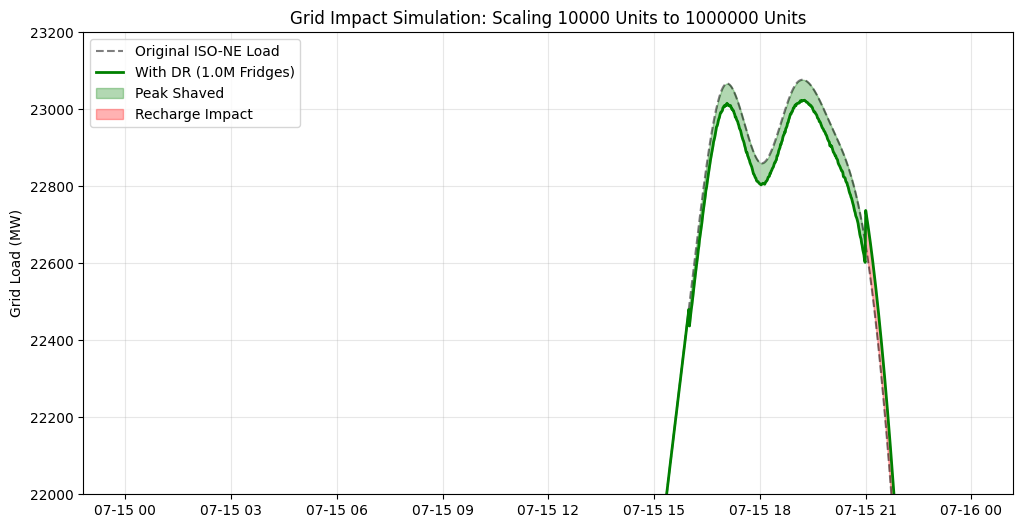

In [47]:
# ==========================================
# 4. VISUALIZATION
# ==========================================
plt.figure(figsize=(12, 6))

# Plot Original vs New
plt.plot(df_grid_min.index[:sim_len], original_grid_profile, 'k--', alpha=0.5, label='Original ISO-NE Load')
plt.plot(df_grid_min.index[:sim_len], new_grid_profile, 'g-', linewidth=2, label=f'With DR ({TARGET_DEPLOYMENT/1e6:.1f}M Fridges)')

# Fill the difference to highlight the "Peak Shaving"
plt.fill_between(
    df_grid_min.index[:sim_len], 
    original_grid_profile, 
    new_grid_profile, 
    where=(original_grid_profile > new_grid_profile),
    color='green', alpha=0.3, label='Peak Shaved'
)

# Fill the "Rebound" (Charging)
plt.fill_between(
    df_grid_min.index[:sim_len], 
    original_grid_profile, 
    new_grid_profile, 
    where=(original_grid_profile < new_grid_profile),
    color='red', alpha=0.3, label='Recharge Impact'
)

plt.title(f"Grid Impact Simulation: Scaling {SIMULATED_COUNT} Units to {TARGET_DEPLOYMENT} Units")
plt.ylabel("Grid Load (MW)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([22000, 23200])
plt.show()

In [48]:
# ==========================================
# 5. KEY METRICS PRINT OUT
# ==========================================
original_peak = np.max(original_grid_profile)
new_peak = np.max(new_grid_profile)
mw_reduction = original_peak - new_peak
pct_reduction = (mw_reduction / original_peak) * 100

print(f"--- RESULTS SUMMARY ---")
print(f"Original Grid Peak: {original_peak:.2f} MW")
print(f"New Grid Peak:      {new_peak:.2f} MW")
print(f"Peak Reduction:     {mw_reduction:.2f} MW (-{pct_reduction:.2f}%)")

--- RESULTS SUMMARY ---
Original Grid Peak: 23076.77 MW
New Grid Peak:      23023.63 MW
Peak Reduction:     53.14 MW (-0.23%)
